# Anomaly detection - Credit card transactions - using Autoencoder

In [993]:
# Import libraries

# Pandas for data frame
import pandas as pd

# Tensorflow for modelling
import tensorflow as tf

# Numerical calculation
import numpy as np

# For statistical test
from scipy.stats import ttest_ind

# Scaler
from sklearn.preprocessing import StandardScaler

# For metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve

# matplotlib for plots
import matplotlib.pyplot as plt

# Seaborn for plots
import seaborn as sns

### Load train, dev and test data from previous notebook

In [994]:
# Import data
df_train = pd.read_csv('C:\\Myprojects\\Dev\\py3\\creditcard_train.csv')
df_dev = pd.read_csv('C:\\Myprojects\\Dev\\py3\\creditcard_dev.csv')
df_test = pd.read_csv('C:\\Myprojects\\Dev\\py3\\creditcard_test.csv')

In [995]:
# Concatenate train and dev for model fitting
df_traindev = pd.concat([df_train,df_dev])

In [996]:
# Columns for training
features = df_traindev.columns[2:31]
impcol=features
impcol

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

### Feature importance

In [997]:
#Feature importance using df_traindev and df_devfraud - using t-test
val1,val2=ttest_ind(df_traindev[df_traindev.Class==0][features], df_traindev[df_traindev.Class==1][features],axis=0, equal_var=False)
Feat_imp = pd.DataFrame({'columns':features[np.argsort(val2)],'pval':val2[np.argsort(val2)]})
Feat_imp

,columns,pval
0,V14,8.686017e-70
1,V4,8.342289e-67
2,V11,2.419406e-61
3,V12,2.304468e-54
4,V10,2.037737e-46
5,V16,3.081924e-41
6,V9,1.462521e-40
7,V3,1.766157e-38
8,V17,2.509562e-34
9,V2,7.046266e-33


In [998]:
# Select top 12 features
# Note: You would have to do trial and error and come up with right number of features
impcol=Feat_imp[:12]['columns']
impcol

0     V14
1      V4
2     V11
3     V12
4     V10
5     V16
6      V9
7      V3
8     V17
9      V2
10     V6
11     V7
Name: columns, dtype: object

### Model creation

In [999]:
# Setup the model
tf.random.set_seed(306)
model = tf.keras.models.Sequential()

In [1000]:
#Define layer sizes. This would again be trying different combinations
layer_sizes = [len(impcol),14,7,14,len(impcol)]
activ_fn = ['N/A','relu','relu','relu',None]

In [1001]:
# Construct the model
for i in range(len(layer_sizes))[1:]:
    model.add(
    tf.keras.layers.Dense(
    layer_sizes[i],
    activation=None,
    use_bias=True,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=layer_sizes[i-1]**-0.5))
    )
    
    if activ_fn[i] != None :
        #model.add(tf.keras.layers.BatchNormalization(momentum=0.99))
        model.add(tf.keras.layers.Activation(activ_fn[i]))
    

In [1002]:
#Define early stopping parameter
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,verbose=0,min_delta=0.01)

In [1003]:
#Model Compiler
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mse'])

In [1004]:
# Setup to Normalize the data
scaler=StandardScaler()
scaler.fit(df_train[impcol])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [1005]:
# Normalize the training data and train
X_train=scaler.transform(df_train[impcol])
X_dev=scaler.transform(df_dev[df_dev.Class==0][impcol])
history=model.fit(
    X_train,X_train,
    epochs = 250, 
    batch_size=1024,
    verbose=0,
    validation_data=(X_dev,X_dev),
    callbacks=[earlystopping]
    )

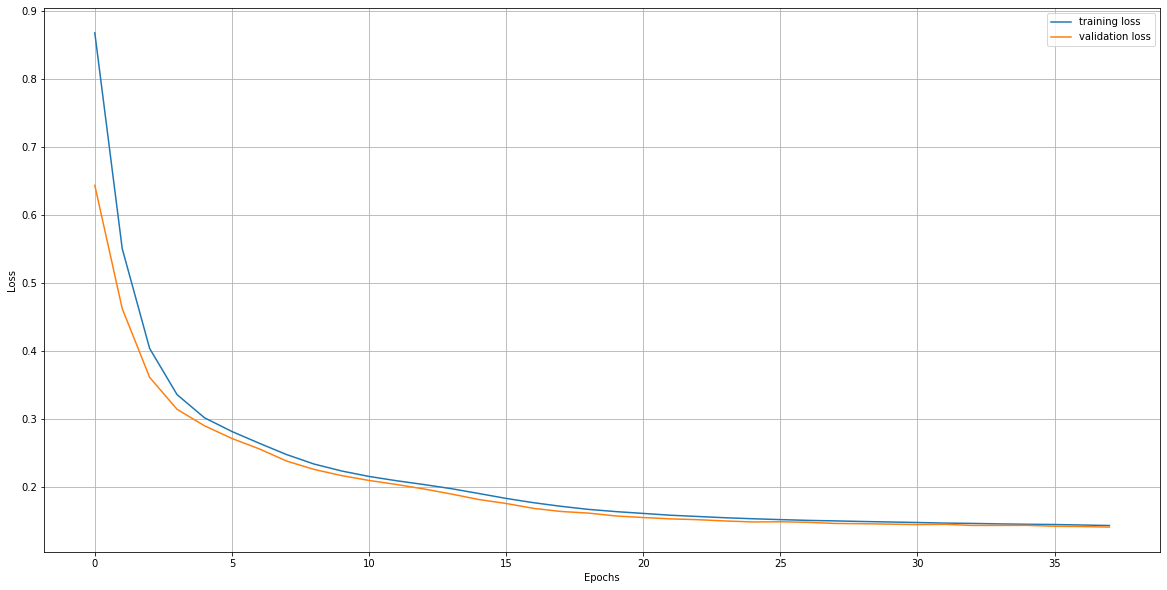

In [1006]:
# Plot training and validation loss
fig = plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

### Prediction on train/dev data

In [1007]:
# Reconstruction error on test data
X_dev=scaler.transform(df_dev[impcol])
Recon_err_train = np.mean(np.power((model.predict(X_dev)-X_dev),2),axis=1)
Recon_err_train.shape

(57109,)

Histogram plots of all features, label


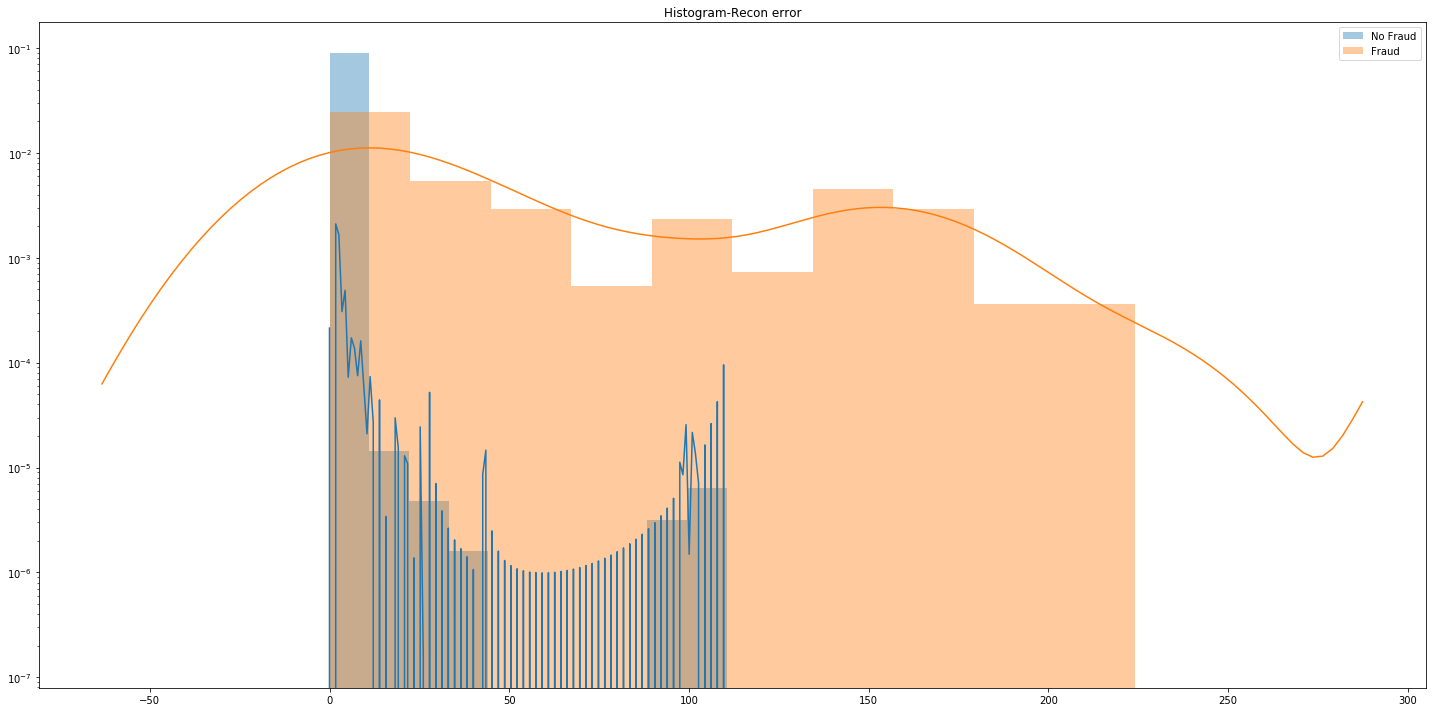

In [1008]:
# Lets plot histogram of errors
print('Histogram plots of all features, label')
fig = plt.figure(figsize=(20,10))
sns.distplot(Recon_err_train[df_dev.Class==0],bins=10)
sns.distplot(Recon_err_train[df_dev.Class==1],bins=10)
plt.legend(['No Fraud', 'Fraud'])
plt.title("Histogram-Recon error")
plt.yscale('log')
plt.tight_layout() 
plt.show()

In [1009]:
# Find threshold
def find_th(Actual,Prediction,Plot=False):
    pr, re, th = precision_recall_curve(Actual,Prediction)
    f1 = 2*pr*re/(pr+re+1e-20)
    if Plot==True:
        plt.plot(th,pr[:-1],label='precision',color='blue')
        plt.plot(th,re[:-1],label='recall',color='green')
        plt.plot(th,f1[:-1],label='f1',color='red')
        plt.legend()
        plt.ylabel('Scores')
        plt.xlabel('Threshold')
        plt.title('Score vs Threshold')
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    return (th[np.argmax(f1)],pr[np.argmax(f1)],re[np.argmax(f1)],np.max(f1))

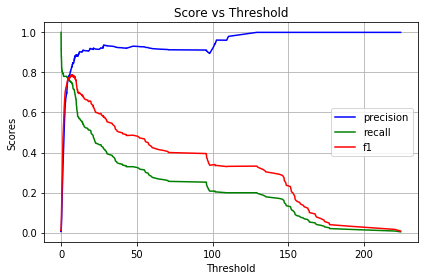

Threshold: 7.523811606513413 
F1-score: 0.7887931034482758 
Recall: 0.8394495412844036 
Precision: 0.7439024390243902


In [1010]:
# Search within min and max with log scale
th,recall,precision,bestF1 = find_th(df_dev.Class,Recon_err_train,Plot=True)

# Scores
print('Threshold: {} \nF1-score: {} \nRecall: {} \nPrecision: {}'.format(th,bestF1,recall,precision))


### Scores on test (Unknown) data

In [1011]:
# Reconstruction error on test data
X_test=scaler.transform(df_test[impcol])
Recon_err_test = np.mean(np.power((model.predict(X_test)-X_test),2),axis=1)
Recon_err_test.shape

(57109,)

In [1012]:
# Test prediction using threshold chosen on dev data
Test_pred = np.array([1 if x>th else 0 for x in Recon_err_test])

In [1013]:
# Print Scores
test_recall,test_precision,test_f1,test_acc=precision_score(df_test.Class,Test_pred), recall_score(df_test.Class,Test_pred), f1_score(df_test.Class,Test_pred), accuracy_score(df_test.Class,Test_pred)
print('F1-score: {} \nRecall: {} \nPrecision: {} \nAccuracy: {}'.format(test_f1,test_recall,test_precision,test_acc))

# Confusion matrix
confusion_matrix(df_test.Class,Test_pred)

F1-score: 0.8195329087048832 
Recall: 0.8577777777777778 
Precision: 0.7845528455284553 
Accuracy: 0.9985116181337442


array([[56831,    32],
       [   53,   193]], dtype=int64)